In [34]:
%matplotlib notebook
import numpy as np
from elastica import *
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
# from leg_sim import *
class LegSimulator(
    BaseSystemCollection, Constraints, Connections, Forcing, CallBacks
):
    pass
# Callback functions
# Add call backs
class RodCallback(CallBackBaseClass):
    """
    Call back function for testing joints
    """

    def __init__(self, step_skip: int, callback_params: dict):
        CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    def make_callback(self, system, time, current_step: int):
        if current_step % self.every == 0:
            self.callback_params["time"].append(time)
            self.callback_params["step"].append(current_step)
            self.callback_params["position"].append(system.position_collection.copy())
            self.callback_params["velocity"].append(system.velocity_collection.copy())
            return
def run_leg_sim(leg_angle, foot_angle, dt=1e-4):
    leg_sim = LegSimulator()

    # setting up test params
    n_elem = 2
    start_rod_1 = np.array([0.0, 0.0, 1.5])
    direction1 = np.array([0.0, 0.0, -1.0])
    # direction2 = np.array([1.0, 0.0, 0.0])
    
#     leg_angle = 0
    direction2 = np.array([np.cos(leg_angle), 0.0, np.sin(leg_angle)])
    normal1 = np.array([1.0, 0.0, 0.0])
    # normal2 = np.array([0.0, 0.0, 1.0])
    normal2 = np.array([np.cos(leg_angle+np.pi/2), 0.0, np.sin(leg_angle+np.pi/2)])

    roll_direction = np.array([0.0, 1.0, 0.0])#np.cross(direction1, normal1)
    base_length = 0.5
    base_radius = 0.25
    base_area = np.pi * base_radius ** 2
    density = 5000
    nu = 0.1
    E = 1e6
    # For shear modulus of 1e4, nu is 99!
    poisson_ratio = 0
    shear_modulus = E / (poisson_ratio + 1.0)
    shear_modulus_unshearable = E / (-0.7 + 1.0)

    # Create rod 1
    torso = CosseratRod.straight_rod(
        n_elem,
        start_rod_1,
        direction1,
        normal1,
        base_length,
        base_radius,
        density,
        nu,
        E,
        shear_modulus=shear_modulus_unshearable,
        poisson_ratio=poisson_ratio
    )
    leg_sim.append(torso)
    start_rod_2 = start_rod_1 + direction1 * base_length

    straight_leg = CosseratRod.straight_rod(
        n_elem,
        start_rod_2,
        direction2,
        normal2,
        base_length,
        base_radius/2,
        density,
        nu,
        E,
        shear_modulus=shear_modulus_unshearable,
        poisson_ratio=poisson_ratio
    )
    leg_sim.append(straight_leg)
    start_rod_3 = start_rod_2 + direction2 * base_length
#     foot_angle = -np.pi/4
    direction3 = np.array([np.cos(foot_angle), 0.0, np.sin(foot_angle)])
    normal3 = np.array([np.cos(foot_angle+np.pi/2), 0.0, np.sin(foot_angle+np.pi/2)])

    foot = CosseratRod.straight_rod(
        n_elem,
        start_rod_3,
        direction3,
        normal3,
        base_length/3,
        base_radius,
        density,
        nu,
        E,
        shear_modulus=shear_modulus_unshearable,
        poisson_ratio=poisson_ratio
    )
    leg_sim.append(foot)

    leg_sim.constrain(torso).using(
        OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
    )

    # Connect rod 1 and rod 2
    leg_sim.connect(
        first_rod=torso, second_rod=straight_leg, first_connect_idx=-1, second_connect_idx=0
    ).using(
        HingeJoint, k=1e6, nu=0, kt=5e3, normal_direction=roll_direction
    )  # 1e-2

    leg_sim.connect(
        first_rod=straight_leg, second_rod=foot, first_connect_idx=-1, second_connect_idx=0
    ).using(
        FixedJoint, k=1e6, nu=10, kt=1e4
        
    )  # 1e-2
    final_time = 1
    # leg_sim.add_forcing_to(rod1).using(
    #     GravityForces
    # )
    # leg_sim.add_forcing_to(straight_leg).using(
    #     GravityForces, acc_gravity=np.array([0, 0, -9.8])
    # )
    leg_sim.add_forcing_to(foot).using(
        GravityForces, acc_gravity=np.array([0, 0, -9.8])
    )
    pp_list_torso = defaultdict(list)
    pp_list_straight_leg = defaultdict(list)
    pp_list_foot = defaultdict(list)
    leg_sim.collect_diagnostics(torso).using(
        RodCallback, step_skip=1000, callback_params=pp_list_torso
    )
    leg_sim.collect_diagnostics(straight_leg).using(
        RodCallback, step_skip=1000, callback_params=pp_list_straight_leg
    )
    leg_sim.collect_diagnostics(foot).using(
        RodCallback, step_skip=1000, callback_params=pp_list_foot
    )
    leg_sim.finalize()

    timestepper = PositionVerlet()
    # timestepper = PEFRL()

    dl = base_length / n_elem
#     dt = 1e-4
    total_steps = int(final_time / dt)
    print("Total steps", total_steps)
    integrate(timestepper, leg_sim, final_time, total_steps)
    max_timesteps = len(pp_list_torso['time'])
    return pp_list_torso, pp_list_straight_leg, pp_list_foot

In [35]:
leg_angle, foot_angle = 0, -np.pi/4
pp_list_torso, pp_list_straight_leg, pp_list_foot = run_leg_sim(leg_angle, foot_angle, dt=1e-4)

Total steps 10000


100%|███████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2617.75it/s]

Final time of simulation is :  0.9999999999998981


<IPython.core.display.Javascript object>


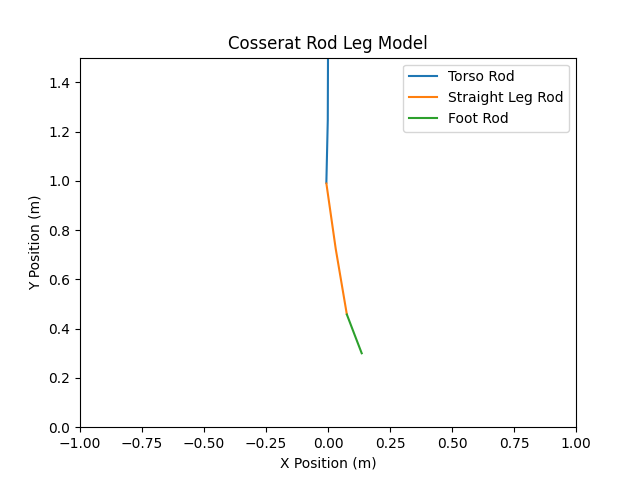

In [36]:
timestep = 5
x_vals_t, y_vals_t, z_vals_t = [pp_list_torso['position'][timestep][i] for i in range(3)]
x_vals_c, y_vals_c, z_vals_c = [pp_list_straight_leg['position'][timestep][i] for i in range(3)]
x_vals_f, y_vals_f, z_vals_f = [pp_list_foot['position'][timestep][i] for i in range(3)]

fig, ax = plt.subplots()
torso_line = ax.plot(x_vals_t, z_vals_t, label="Torso Rod")
straight_leg_line  = ax.plot(x_vals_c, z_vals_c, label="Straight Leg Rod")
foot_line  = ax.plot(x_vals_f, z_vals_f, label="Foot Rod")
ax.set_title("Cosserat Rod Leg Model")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.set_xlim(-1,1)
ax.set_ylim(0,1.5)
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


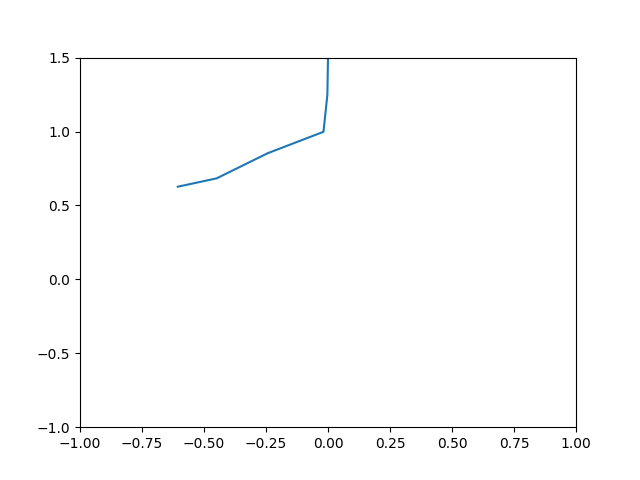

In [40]:
fig, ax = plt.subplots()
timestep = 0
x_vals, y_vals, z_vals = [pp_list_torso['position'][timestep][i] for i in range(3)]
x_vals, y_vals, z_vals = [np.append(vals, pp_list_straight_leg['position'][timestep][c]) for c, vals in enumerate([x_vals, y_vals, z_vals])]
x_vals, y_vals, z_vals = [np.append(vals, pp_list_foot['position'][timestep][c]) for c, vals in enumerate([x_vals, y_vals, z_vals])]

line, = ax.plot(x_vals, z_vals)
def animate(timestep):
#     line.remove()
    global line
    if timestep != len(pp_list_torso['position']) -1:
        line.remove()
    x_vals, y_vals, z_vals = [pp_list_torso['position'][timestep][i] for i in range(3)]
    x_vals, y_vals, z_vals = [np.append(vals, pp_list_straight_leg['position'][timestep][c]) for c, vals in enumerate([x_vals, y_vals, z_vals])]
    x_vals, y_vals, z_vals = [np.append(vals, pp_list_foot['position'][timestep][c]) for c, vals in enumerate([x_vals, y_vals, z_vals])]

    # line.set(np.sin(x + i / 50))  # update the data.
    line, = ax.plot(x_vals, z_vals)
    
    return line
ani = animation.FuncAnimation(
    fig, animate, interval=200)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1.5)
# ax.set(xlim3d=(-1, 1), xlabel='X')
    # ax.set(ylim3d=(-1, 1), ylabel='Y')
# ax.set(zlim3d=(-1, 1), zlabel='Z')
plt.show()

<IPython.core.display.Javascript object>


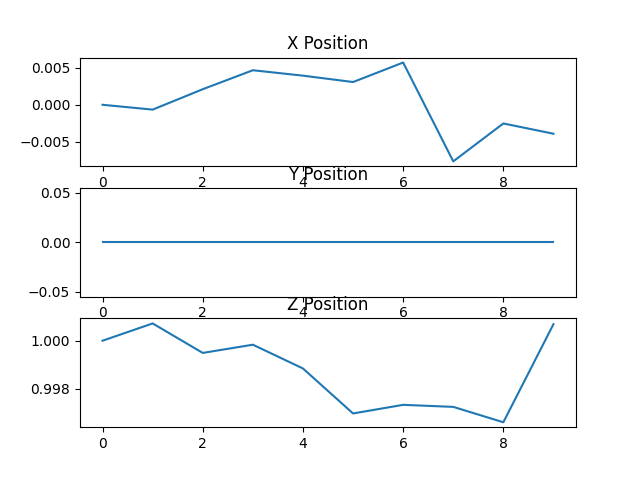

10


In [29]:
end_node_x = []
end_node_y = []
end_node_z = []

for timestep in range(max_timesteps):
    end_node_x.append(pp_list_torso['position'][timestep][0][-1])
    end_node_y.append(pp_list_torso['position'][timestep][1][-1])
    end_node_z.append(pp_list_torso['position'][timestep][2][-1])
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.plot(end_node_x)
ax1.set_title("X Position")
ax2.plot(end_node_y)
ax2.set_title("Y Position")
ax3.plot(end_node_z)
ax3.set_title("Z Position")
print(max_timesteps)

<IPython.core.display.Javascript object>


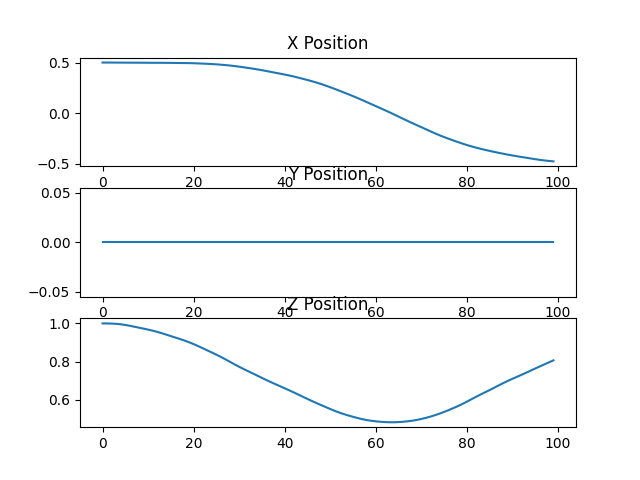

100


In [35]:
end_node_x = []
end_node_y = []
end_node_z = []

for timestep in range(max_timesteps):
    end_node_x.append(pp_list_straight_leg['position'][timestep][0][-1])
    end_node_y.append(pp_list_straight_leg['position'][timestep][1][-1])
    end_node_z.append(pp_list_straight_leg['position'][timestep][2][-1])
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.plot(end_node_x)
ax1.set_title("X Position")
ax2.plot(end_node_y)
ax2.set_title("Y Position")
ax3.plot(end_node_z)
ax3.set_title("Z Position")

print(max_timesteps)

<IPython.core.display.Javascript object>


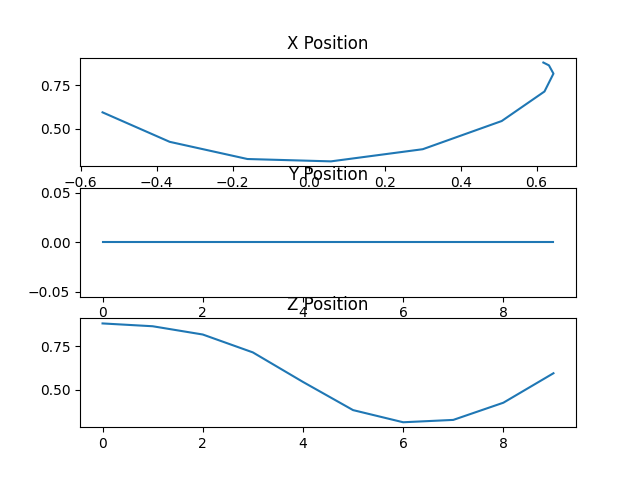

6
[[-2.07655218 -2.21501604 -2.31069737]
 [ 0.          0.          0.        ]
 [-0.26170415 -0.25593099 -0.24588283]]
2.3237428226169734


In [42]:
end_node_x = []
end_node_y = []
end_node_z = []

for timestep in range(max_timesteps):
    end_node_x.append(pp_list_foot['position'][timestep][0][-1])
    end_node_y.append(pp_list_foot['position'][timestep][1][-1])
    end_node_z.append(pp_list_foot['position'][timestep][2][-1])
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.plot(end_node_x, end_node_z)
ax1.set_title("X Position")
ax2.plot(end_node_y)
ax2.set_title("Y Position")
ax3.plot(end_node_z)
ax3.set_title("Z Position")
low_timestep = np.argmin(np.array(end_node_z))
print(low_timestep)
print(pp_list_foot['velocity'][low_timestep])
max_foot_vel = np.linalg.norm(pp_list_foot['velocity'][low_timestep][:,-1])
print(max_foot_vel)

<IPython.core.display.Javascript object>


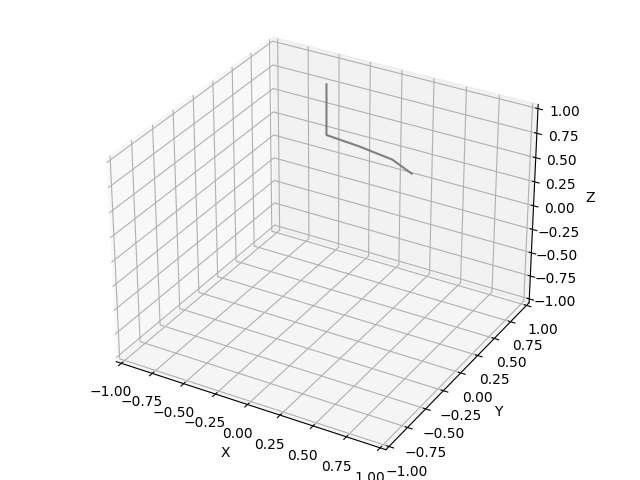

/tmp/ipykernel_1657/1601479406.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


In [36]:
fig = plt.figure()
ax = p3.Axes3D(fig)
x_vals, y_vals, z_vals = [pp_list_torso['position'][timestep][i] for i in range(3)]
x_vals, y_vals, z_vals = [np.append(vals, pp_list_straight_leg['position'][timestep][c]) for c, vals in enumerate([x_vals, y_vals, z_vals])]
x_vals, y_vals, z_vals = [np.append(vals, pp_list_foot['position'][timestep][c]) for c, vals in enumerate([x_vals, y_vals, z_vals])]

line, = ax.plot(x_vals, y_vals, z_vals)
def animate(timestep):
#     line.remove()
    global line
    if timestep != len(pp_list_torso['position']) -1:
        line.remove()
    x_vals, y_vals, z_vals = [pp_list_torso['position'][timestep][i] for i in range(3)]
    x_vals, y_vals, z_vals = [np.append(vals, pp_list_straight_leg['position'][timestep][c]) for c, vals in enumerate([x_vals, y_vals, z_vals])]
    x_vals, y_vals, z_vals = [np.append(vals, pp_list_foot['position'][timestep][c]) for c, vals in enumerate([x_vals, y_vals, z_vals])]

    # line.set(np.sin(x + i / 50))  # update the data.
    line, = ax.plot(x_vals, y_vals, z_vals)
    
    return line
ani = animation.FuncAnimation(
    fig, animate, interval=50)
ax.set(xlim3d=(-1, 1), xlabel='X')
ax.set(ylim3d=(-1, 1), ylabel='Y')
ax.set(zlim3d=(-1, 1), zlabel='Z')
plt.show()